Mount the drive and reduce the size of the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Importing the required libraries

In [ ]:
!pip install torch
!pip install torch-geometric
!pip install transformers
!pip install scikit-learn
!pip install tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# ***Method-1*** : Extracting llm embeddings and then using it along with the additional features for predicting the virality score through GCN

In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_dataset_reddit.csv')
df_one_hot = pd.get_dummies(df['subreddit'], prefix='subreddit')

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        # Use the mean pooling of embeddings across tokens (instead of [CLS] token)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the text column in batches
texts = df['body']  # Replace 'body' with your actual text column
text_embeddings = get_embeddings(texts)

# Convert embeddings to torch tensor
text_embeddings = torch.tensor(text_embeddings, dtype=torch.float)

# Select additional features from the dataset
additional_features = torch.tensor(df_one_hot[['subreddit_gameofthrones', 'subreddit_politics',
                                                'subreddit_worldnews', 'subreddit_relationship_advice',
                                                'subreddit_nba', 'subreddit_freefolk']].values,
                                    dtype=torch.float)

# Concatenate text embeddings and additional features
X = torch.cat([text_embeddings, additional_features], dim=1)

# Split dataset into training and testing sets
y = torch.tensor(df['score'].values, dtype=torch.float)  # Replace 'score' with your actual target column
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# K-Nearest Neighbors (KNN) to create edges
def create_edge_index_knn(data, k=5):
    """Function to create KNN-based edges."""
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    edge_index = []
    for i in range(data.shape[0]):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Parameters
k = 15  # Number of nearest neighbors for KNN

# Generate edge_index using KNN for the entire training set
edge_index_train = create_edge_index_knn(X_train, k)

# Define GNN model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=500,hidden_dim3=200,hidden_dim4=60, output_dim=1):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.fc = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        x = self.conv4(x, edge_index)
        x = torch.relu(x)

        # Fully connected layer for the final output (virality score)
        x = self.fc(x)
        return x

# Initialize the GNN model
input_dim = X.shape[1]  # Combined dimension of DistilBERT embeddings and additional features
model = GNNModel(input_dim=input_dim)

# Move the model to device (GPU/CPU)
model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()  # Assuming the virality score is a continuous integer value
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert training and testing sets to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

# Training loop without batching
num_epochs = 500

for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    # Forward pass for the entire training set
    output = model(X_train_tensor, edge_index_train.to(device)).squeeze()

    # Calculate loss
    loss = criterion(output, y_train_tensor)

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Optionally, you can evaluate the model on the test set here.
model.eval()
with torch.no_grad():
    # Create edge index for the test set (optional, if you need to evaluate on edges)
    edge_index_test = create_edge_index_knn(X_test, k).to(device)

    # Forward pass on the test set
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model(test_X_tensor, edge_index_test).squeeze()

    # Compute the test loss if you have the corresponding test labels
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')


Epoch 1/500, Loss: 1535.1337
Epoch 2/500, Loss: 1684.0232
Epoch 3/500, Loss: 1533.3690
Epoch 4/500, Loss: 1534.5195
Epoch 5/500, Loss: 1533.8191
Epoch 6/500, Loss: 1530.7555
Epoch 7/500, Loss: 1524.0878
Epoch 8/500, Loss: 1511.9929
Epoch 9/500, Loss: 1496.0482
Epoch 10/500, Loss: 1493.9531
Epoch 11/500, Loss: 1503.9839
Epoch 12/500, Loss: 1492.7831
Epoch 13/500, Loss: 1487.9139
Epoch 14/500, Loss: 1490.0503
Epoch 15/500, Loss: 1492.4976
Epoch 16/500, Loss: 1492.8041
Epoch 17/500, Loss: 1490.8375
Epoch 18/500, Loss: 1487.3854
Epoch 19/500, Loss: 1484.1494
Epoch 20/500, Loss: 1483.4850
Epoch 21/500, Loss: 1485.5557
Epoch 22/500, Loss: 1485.9188
Epoch 23/500, Loss: 1483.1696
Epoch 24/500, Loss: 1480.9966
Epoch 25/500, Loss: 1480.9067
Epoch 26/500, Loss: 1481.6305
Epoch 27/500, Loss: 1481.8239
Epoch 28/500, Loss: 1481.0491
Epoch 29/500, Loss: 1479.6622
Epoch 30/500, Loss: 1478.5330
Epoch 31/500, Loss: 1478.4357
Epoch 32/500, Loss: 1479.0248
Epoch 33/500, Loss: 1478.9915
Epoch 34/500, Loss:

# ***Method-1 P-2*** : Extracting llm embeddings and then using it along with the additional features for predicting the virality score through GAT

In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GATConv
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_dataset_reddit.csv')
df_one_hot = pd.get_dummies(df['subreddit'], prefix='subreddit')

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the text column
texts = df['body']
text_embeddings = get_embeddings(texts)
text_embeddings = torch.tensor(text_embeddings, dtype=torch.float)

# Select additional features
additional_features = torch.tensor(df_one_hot.values, dtype=torch.float)

# Concatenate text embeddings and additional features
X = torch.cat([text_embeddings, additional_features], dim=1)

# Split dataset into training and testing sets
y = torch.tensor(df['score'].values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# Function to create edge index using KNN
def create_edge_index_knn(data, k=5):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    _, indices = nbrs.kneighbors(data)
    edge_index = []
    for i in range(data.shape[0]):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Parameters
k = 15
edge_index_train = create_edge_index_knn(X_train, k)

# Define GAT model
class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=500, hidden_dim3=200, hidden_dim4=60, output_dim=1, heads=4):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim1, heads=heads)
        self.conv2 = GATConv(hidden_dim1 * heads, hidden_dim2, heads=heads)
        self.conv3 = GATConv(hidden_dim2 * heads, hidden_dim3, heads=heads)
        self.conv4 = GATConv(hidden_dim3 * heads, hidden_dim4, heads=heads)
        self.fc = nn.Linear(hidden_dim4 * heads, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Initialize GAT model
input_dim = X.shape[1]
model = GATModel(input_dim=input_dim)
model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert training data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor, edge_index_train.to(device)).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Evaluate on test set
model.eval()
with torch.no_grad():
    edge_index_test = create_edge_index_knn(X_test, k).to(device)
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model(test_X_tensor, edge_index_test).squeeze()
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')


Epoch 1/500, Loss: 1534.3809
Epoch 2/500, Loss: 2048347.0000
Epoch 3/500, Loss: 1486.3187
Epoch 4/500, Loss: 1584.0054
Epoch 5/500, Loss: 1541.5175
Epoch 6/500, Loss: 1501.3237
Epoch 7/500, Loss: 1569.5597
Epoch 8/500, Loss: 1497.3683
Epoch 9/500, Loss: 1523.7749
Epoch 10/500, Loss: 1518.7014
Epoch 11/500, Loss: 1493.0240
Epoch 12/500, Loss: 1497.0538
Epoch 13/500, Loss: 1486.2109
Epoch 14/500, Loss: 1492.2892
Epoch 15/500, Loss: 1486.8528
Epoch 16/500, Loss: 1480.8640
Epoch 17/500, Loss: 1483.2509
Epoch 18/500, Loss: 1479.4443
Epoch 19/500, Loss: 1473.2670
Epoch 20/500, Loss: 1475.8508
Epoch 21/500, Loss: 1483.4203
Epoch 22/500, Loss: 1473.6963
Epoch 23/500, Loss: 1460.6692
Epoch 24/500, Loss: 1468.1377
Epoch 25/500, Loss: 1486.2356
Epoch 26/500, Loss: 1458.2960
Epoch 27/500, Loss: 1464.9655
Epoch 28/500, Loss: 1446.5037
Epoch 29/500, Loss: 1439.0510
Epoch 30/500, Loss: 1455.3193
Epoch 31/500, Loss: 1411.9213
Epoch 32/500, Loss: 1401.9559
Epoch 33/500, Loss: 1415.2075
Epoch 34/500, Lo

# ***Method-2*** : Extracting llm embeddings and along with additional features we use a ml model (Random forest regressor) to predict the same.

In [ ]:
import torch
from torch import nn
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_dataset_reddit.csv')
df_one_hot = pd.get_dummies(df['subreddit'], prefix='subreddit')

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        # Use the mean pooling of embeddings across tokens (instead of [CLS] token)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the text column in batches
texts = df['body']  # Replace 'body' with your actual text column
text_embeddings = get_embeddings(texts)

# Select additional features from the dataset
additional_features = torch.tensor(df_one_hot[['subreddit_gameofthrones', 'subreddit_politics',
                                                'subreddit_worldnews', 'subreddit_relationship_advice',
                                                'subreddit_nba', 'subreddit_freefolk']].values,
                                    dtype=torch.float)
print(f'Shape of text_embeddings: {text_embeddings.shape}')
print(f'Shape of additional_features: {additional_features.shape}')

# Concatenate text embeddings and additional features
X = np.hstack([text_embeddings, additional_features])

# Define target variable
y = df['score'].values  # Replace 'score' with your actual target column

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)

# Compute and print test loss (e.g., Mean Squared Error)
mse = np.mean((test_predictions - y_test) ** 2)
print(f'Test Mean Squared Error: {mse:.4f}')


Shape of text_embeddings: (600, 768)
Shape of additional_features: torch.Size([600, 6])
Test Mean Squared Error: 3437.0377


# ***Method-3*** : Using tf-idf vectoriser for the text data and then use it as feature apart from the additional features on a ml model.

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_dataset_reddit.csv')

# Check if the necessary columns exist in the dataset
# Extracting text from the 'body' column and defining the target variable
texts = df['body']
y = df['score']  # Continuous target variable

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

# Fit and transform the text data to generate TF-IDF features
X_tfidf = vectorizer.fit_transform(texts)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')


Mean Squared Error: 4051.6476
R-squared: -0.2406


# ***Method-4***: using Tf-idf vectorizer and gnn to do the same prediction.


In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_dataset_reddit.csv')
df_one_hot = pd.get_dummies(df['subreddit'], prefix='subreddit')

# Define tokenizer and model for DistilBERT (No longer needed for TF-IDF)
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to get TF-IDF embeddings
def get_tfidf_embeddings(texts):
    tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limit to 5000 features for better performance
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    return torch.tensor(tfidf_matrix.toarray(), dtype=torch.float)

# Get TF-IDF embeddings for the text column
texts = df['body']  # Replace 'body' with your actual text column
text_embeddings = get_tfidf_embeddings(texts)

# Select additional features from the dataset
additional_features = torch.tensor(df_one_hot[['subreddit_gameofthrones', 'subreddit_politics',
                                                'subreddit_worldnews', 'subreddit_relationship_advice',
                                                'subreddit_nba', 'subreddit_freefolk']].values,
                                    dtype=torch.float)

# Concatenate text embeddings and additional features
X = torch.cat([text_embeddings, additional_features], dim=1)

# Split dataset into training and testing sets
y = torch.tensor(df['score'].values, dtype=torch.float)  # Replace 'score' with your actual target column
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# K-Nearest Neighbors (KNN) to create edges
def create_edge_index_knn(data, k=5):
    """Function to create KNN-based edges."""
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    edge_index = []
    for i in range(data.shape[0]):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Parameters
k = 15  # Number of nearest neighbors for KNN

# Generate edge_index using KNN for the entire training set
edge_index_train = create_edge_index_knn(X_train, k)

# Define GNN model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=500, hidden_dim3=200, hidden_dim4=60, output_dim=1):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.fc = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        x = self.conv4(x, edge_index)
        x = torch.relu(x)

        # Fully connected layer for the final output (virality score)
        x = self.fc(x)
        return x

# Initialize the GNN model
input_dim = X.shape[1]  # Combined dimension of TF-IDF embeddings and additional features
model = GNNModel(input_dim=input_dim)

# Move the model to device (GPU/CPU)
model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()  # Assuming the virality score is a continuous integer value
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert training and testing sets to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

# Training loop without batching
num_epochs = 500

for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    # Forward pass for the entire training set
    output = model(X_train_tensor, edge_index_train.to(device)).squeeze()

    # Calculate loss
    loss = criterion(output, y_train_tensor)

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Optionally, you can evaluate the model on the test set here.
model.eval()
with torch.no_grad():
    # Create edge index for the test set (optional, if you need to evaluate on edges)
    edge_index_test = create_edge_index_knn(X_test, k).to(device)

    # Forward pass on the test set
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model(test_X_tensor, edge_index_test).squeeze()

    # Compute the test loss if you have the corresponding test labels
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')


Epoch 1/500, Loss: 1534.3875
Epoch 2/500, Loss: 1500.0795
Epoch 3/500, Loss: 1885.8322
Epoch 4/500, Loss: 1490.7983
Epoch 5/500, Loss: 1519.3062
Epoch 6/500, Loss: 1530.7145
Epoch 7/500, Loss: 1533.0515
Epoch 8/500, Loss: 1533.3130
Epoch 9/500, Loss: 1533.0995
Epoch 10/500, Loss: 1532.7345
Epoch 11/500, Loss: 1532.2312
Epoch 12/500, Loss: 1531.5188
Epoch 13/500, Loss: 1530.5568
Epoch 14/500, Loss: 1529.2365
Epoch 15/500, Loss: 1527.4252
Epoch 16/500, Loss: 1524.9370
Epoch 17/500, Loss: 1521.5386
Epoch 18/500, Loss: 1516.9335
Epoch 19/500, Loss: 1510.7855
Epoch 20/500, Loss: 1502.8652
Epoch 21/500, Loss: 1493.5225
Epoch 22/500, Loss: 1485.1348
Epoch 23/500, Loss: 1484.5416
Epoch 24/500, Loss: 1494.0226
Epoch 25/500, Loss: 1493.4806
Epoch 26/500, Loss: 1486.1261
Epoch 27/500, Loss: 1481.5803
Epoch 28/500, Loss: 1481.2412
Epoch 29/500, Loss: 1482.6445
Epoch 30/500, Loss: 1483.8319
Epoch 31/500, Loss: 1483.9620
Epoch 32/500, Loss: 1482.9058
Epoch 33/500, Loss: 1481.0594
Epoch 34/500, Loss:

# ***Method-4 P2***: using Tf-idf vectorizer and gat to do the same prediction.


In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GATConv
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_dataset_reddit.csv')
df_one_hot = pd.get_dummies(df['subreddit'], prefix='subreddit')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to get TF-IDF embeddings
def get_tfidf_embeddings(texts):
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    return torch.tensor(tfidf_matrix.toarray(), dtype=torch.float)

# Get TF-IDF embeddings for the text column
texts = df['body']
text_embeddings = get_tfidf_embeddings(texts)

# Select additional features from the dataset
additional_features = torch.tensor(df_one_hot[['subreddit_gameofthrones', 'subreddit_politics',
                                                'subreddit_worldnews', 'subreddit_relationship_advice',
                                                'subreddit_nba', 'subreddit_freefolk']].values,
                                    dtype=torch.float)

# Concatenate text embeddings and additional features
X = torch.cat([text_embeddings, additional_features], dim=1)

# Split dataset into training and testing sets
y = torch.tensor(df['score'].values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# K-Nearest Neighbors (KNN) to create edges
def create_edge_index_knn(data, k=5):
    """Function to create KNN-based edges."""
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    edge_index = []
    for i in range(data.shape[0]):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Parameters
k = 15

# Generate edge_index using KNN for the entire training set
edge_index_train = create_edge_index_knn(X_train, k)

# Define GNN model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=500, hidden_dim3=200, hidden_dim4=60, output_dim=1, heads=8):
        super(GNNModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim1, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim1 * heads, hidden_dim2, heads=heads, concat=True)
        self.conv3 = GATConv(hidden_dim2 * heads, hidden_dim3, heads=heads, concat=True)
        self.conv4 = GATConv(hidden_dim3 * heads, hidden_dim4, heads=1, concat=False)
        self.fc = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Initialize the GNN model
input_dim = X.shape[1]
model = GNNModel(input_dim=input_dim)

# Move the model to device (GPU/CPU)
model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert training and testing sets to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

# Training loop without batching
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor, edge_index_train.to(device)).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Optionally, evaluate the model
model.eval()
with torch.no_grad():
    edge_index_test = create_edge_index_knn(X_test, k).to(device)
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model(test_X_tensor, edge_index_test).squeeze()
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')


Epoch 1/500, Loss: 1533.8457
Epoch 2/500, Loss: 156823.9844
Epoch 3/500, Loss: 1511.4889
Epoch 4/500, Loss: 1517.6553
Epoch 5/500, Loss: 2638.5330
Epoch 6/500, Loss: 1522.4720
Epoch 7/500, Loss: 1536.0259
Epoch 8/500, Loss: 1535.7510
Epoch 9/500, Loss: 1533.9941
Epoch 10/500, Loss: 1530.6277
Epoch 11/500, Loss: 1522.9823
Epoch 12/500, Loss: 1509.7566
Epoch 13/500, Loss: 1504.5629
Epoch 14/500, Loss: 1492.9875
Epoch 15/500, Loss: 1480.7847
Epoch 16/500, Loss: 1473.9805
Epoch 17/500, Loss: 1470.9552
Epoch 18/500, Loss: 1472.9191
Epoch 19/500, Loss: 1473.0914
Epoch 20/500, Loss: 1469.9844
Epoch 21/500, Loss: 1470.7295
Epoch 22/500, Loss: 1469.3387
Epoch 23/500, Loss: 1470.2535
Epoch 24/500, Loss: 1469.7292
Epoch 25/500, Loss: 1469.2524
Epoch 26/500, Loss: 1468.8286
Epoch 27/500, Loss: 1468.3597
Epoch 28/500, Loss: 1468.9203
Epoch 29/500, Loss: 1468.4806
Epoch 30/500, Loss: 1468.6406
Epoch 31/500, Loss: 1468.3779
Epoch 32/500, Loss: 1467.9939
Epoch 33/500, Loss: 1468.1226
Epoch 34/500, Los

# 1) Extracting llm embeddings and then training it on gcn Dataset-2

In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import os

# Set CUDA settings to avoid certain issues
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset and skip problematic rows if they exist
try:
    df = pd.read_csv('/content/sampled_modified_reddit_data.csv', on_bad_lines='skip')
    print("Columns in dataset:", df.columns)  # Print columns to verify the column names
except pd.errors.ParserError:
    print("Parser error encountered. Some rows were skipped due to formatting issues.")

# Check if 'tags' column exists and apply one-hot encoding if available
if 'tags' in df.columns:
    df_one_hot = pd.get_dummies(df['tags'], prefix='tags')
else:
    print("Column 'tags' not found in the dataset. Proceeding without one-hot encoding.")
    df_one_hot = pd.DataFrame()  # Create an empty DataFrame if 'tags' is missing

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        # Use mean pooling of embeddings across tokens
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the 'body' column
texts = df['body']
text_embeddings = get_embeddings(texts)

# Convert embeddings to torch tensor
text_embeddings = torch.tensor(text_embeddings, dtype=torch.float)

# Select additional features from the dataset
additional_features = torch.tensor(df[['Score']].values, dtype=torch.float)  # Changed from 'retweet_count' to 'Score'

# Concatenate text embeddings and additional features
X = torch.cat([text_embeddings, additional_features], dim=1)

# Split dataset into training and testing sets
y = torch.tensor(df['Num of Comments'].values, dtype=torch.float)  # Assuming 'Num of Comments' is the target
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# K-Nearest Neighbors (KNN) to create edges
def create_edge_index_knn(data, k=5):
    """Function to create KNN-based edges."""
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    edge_index = []
    for i in range(data.shape[0]):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Parameters
k = 15  # Number of nearest neighbors for KNN

# Generate edge_index using KNN for the entire training set
edge_index_train = create_edge_index_knn(X_train, k)

# Define GNN model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=500, hidden_dim3=200, hidden_dim4=60, output_dim=1):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.fc = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Initialize the GNN model
input_dim = X.shape[1]
model = GNNModel(input_dim=input_dim)
model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert training and testing sets to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

# Training loop without batching
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor, edge_index_train.to(device)).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Optionally, you can evaluate the model on the test set here.
model.eval()
with torch.no_grad():
    edge_index_test = create_edge_index_knn(X_test, k).to(device)
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model(test_X_tensor, edge_index_test).squeeze()
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')


Columns in dataset: Index(['Political Lean', 'Score', 'Subreddit', 'Num of Comments', 'body'], dtype='object')
Column 'tags' not found in the dataset. Proceeding without one-hot encoding.
Epoch 1/500, Loss: 5113.5093
Epoch 2/500, Loss: 20489.5723
Epoch 3/500, Loss: 5685.7437
Epoch 4/500, Loss: 5277.2925
Epoch 5/500, Loss: 4871.7109
Epoch 6/500, Loss: 4598.0352
Epoch 7/500, Loss: 4251.2314
Epoch 8/500, Loss: 3961.2810
Epoch 9/500, Loss: 4067.0007
Epoch 10/500, Loss: 3952.9634
Epoch 11/500, Loss: 3852.7949
Epoch 12/500, Loss: 3890.3438
Epoch 13/500, Loss: 3887.6804
Epoch 14/500, Loss: 3841.9863
Epoch 15/500, Loss: 3809.0613
Epoch 16/500, Loss: 3824.0352
Epoch 17/500, Loss: 3806.9871
Epoch 18/500, Loss: 3803.8560
Epoch 19/500, Loss: 3801.9314
Epoch 20/500, Loss: 3783.9414
Epoch 21/500, Loss: 3791.5579
Epoch 22/500, Loss: 3776.3508
Epoch 23/500, Loss: 3779.2937
Epoch 24/500, Loss: 3775.6335
Epoch 25/500, Loss: 3773.1875
Epoch 26/500, Loss: 3770.7449
Epoch 27/500, Loss: 3766.1333
Epoch 28/5

# Extracting llm embeddings and then training it on gat Dataset-2

In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GATConv
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import os

# Set CUDA settings to avoid certain issues
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset and skip problematic rows if they exist
try:
    df = pd.read_csv('/content/sampled_modified_reddit_data.csv', on_bad_lines='skip')
    print("Columns in dataset:", df.columns)  # Print columns to verify the column names
except pd.errors.ParserError:
    print("Parser error encountered. Some rows were skipped due to formatting issues.")

# Check if 'tags' column exists and apply one-hot encoding if available
if 'tags' in df.columns:
    df_one_hot = pd.get_dummies(df['tags'], prefix='tags')
else:
    print("Column 'tags' not found in the dataset. Proceeding without one-hot encoding.")
    df_one_hot = pd.DataFrame()  # Create an empty DataFrame if 'tags' is missing

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the 'body' column
texts = df['body']
text_embeddings = get_embeddings(texts)

# Convert embeddings to torch tensor
text_embeddings = torch.tensor(text_embeddings, dtype=torch.float)

# Select additional features from the dataset
additional_features = torch.tensor(df[['Score']].values, dtype=torch.float)  # Changed from 'retweet_count' to 'Score'

# Concatenate text embeddings and additional features
X = torch.cat([text_embeddings, additional_features], dim=1)

# Split dataset into training and testing sets
y = torch.tensor(df['Num of Comments'].values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# K-Nearest Neighbors (KNN) to create edges
def create_edge_index_knn(data, k=5):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    edge_index = []
    for i in range(data.shape[0]):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Parameters
k = 15

# Generate edge_index using KNN for the entire training set
edge_index_train = create_edge_index_knn(X_train, k)

# Define GAT model
class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=500, hidden_dim3=200, hidden_dim4=60, output_dim=1, heads=8):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim1, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim1 * heads, hidden_dim2, heads=heads, concat=True)
        self.conv3 = GATConv(hidden_dim2 * heads, hidden_dim3, heads=heads, concat=True)
        self.conv4 = GATConv(hidden_dim3 * heads, hidden_dim4, heads=1, concat=False)
        self.fc = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Initialize the GAT model
input_dim = X.shape[1]
model = GATModel(input_dim=input_dim)
model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert training and testing sets to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

# Training loop without batching
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor, edge_index_train.to(device)).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Evaluate the model
model.eval()
with torch.no_grad():
    edge_index_test = create_edge_index_knn(X_test, k).to(device)
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model(test_X_tensor, edge_index_test).squeeze()
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')


Columns in dataset: Index(['Political Lean', 'Score', 'Subreddit', 'Num of Comments', 'body'], dtype='object')
Column 'tags' not found in the dataset. Proceeding without one-hot encoding.
Epoch 1/500, Loss: 5126.0205
Epoch 2/500, Loss: 571618816.0000
Epoch 3/500, Loss: 18445.6875
Epoch 4/500, Loss: 4004.9609
Epoch 5/500, Loss: 11450.0684
Epoch 6/500, Loss: 12543.1279
Epoch 7/500, Loss: 4704.5132
Epoch 8/500, Loss: 5147.0952
Epoch 9/500, Loss: 5292.1968
Epoch 10/500, Loss: 4571.4287
Epoch 11/500, Loss: 4643.4243
Epoch 12/500, Loss: 5691.0903
Epoch 13/500, Loss: 3901.7617
Epoch 14/500, Loss: 6038.1987
Epoch 15/500, Loss: 4748.6006
Epoch 16/500, Loss: 4061.0750
Epoch 17/500, Loss: 5699.0405
Epoch 18/500, Loss: 3547.1589
Epoch 19/500, Loss: 4928.4766
Epoch 20/500, Loss: 3821.9785
Epoch 21/500, Loss: 4200.5366
Epoch 22/500, Loss: 3605.9167
Epoch 23/500, Loss: 3822.8992
Epoch 24/500, Loss: 3275.5398
Epoch 25/500, Loss: 3695.8035
Epoch 26/500, Loss: 3015.8577
Epoch 27/500, Loss: 3758.9641
Epo

#2) Extracting llm embeddings and then using an ml model Dataset-2

In [ ]:
import torch
from torch import nn
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/sampled_modified_reddit_data.csv')

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the 'body' column (which seems to contain the text)
texts = df['body']
text_embeddings = get_embeddings(texts)

# Select additional features
additional_features = torch.tensor(df[['Num of Comments']].values, dtype=torch.float)

# Concatenate text embeddings and additional features
X = np.hstack([text_embeddings, additional_features])

# Define target variable
y = df['Score'].values  # Using 'Score' as the target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)

# Compute and print test loss (e.g., Mean Squared Error)
mse = np.mean((test_predictions - y_test) ** 2)
print(f'Test Mean Squared Error: {mse:.4f}')


Test Mean Squared Error: 14241.0452


#3) Tf-idf along with ml model Dataset-2

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/content/sampled_modified_reddit_data.csv')

# Check if the necessary columns exist in the dataset
# Extracting text from the 'body' column and defining the target variable
texts = df['body']
y = df['Score']  # Continuous target variable

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

# Fit and transform the text data to generate TF-IDF features
X_tfidf = vectorizer.fit_transform(texts)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')


Mean Squared Error: 11748.9201
R-squared: -3.3341


#1) Rake

In [ ]:
!pip install rake-nltk

In [ ]:
from rake_nltk import Rake
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

# Load dataset
df = pd.read_csv('/content/sampled_modified_reddit_data.csv')
#df = df.head(1000)

# Check if the necessary columns exist in the dataset
# Extracting text from the 'full_text' column and defining the target variable
texts = df['body']
y = df['Num of Comments']  # Continuous target variable

# Initialize RAKE
rake = Rake()

# Extract key phrases using RAKE for each document
rake_keywords = []
for text in texts:
    rake.extract_keywords_from_text(text)
    key_phrases = rake.get_ranked_phrases()  # Get ranked key phrases
    rake_keywords.append(" ".join(key_phrases))  # Combine key phrases into a single string

# Convert extracted key phrases into a Bag of Words representation
vectorizer = CountVectorizer(max_features=100)  # You can adjust max_features based on the dataset size
X_rake = vectorizer.fit_transform(rake_keywords)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rake, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Mean Squared Error: 3414.7006
R-squared: -0.0691


#2) WordtoVec

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from gensim.models import Word2Vec
import numpy as np

# Load your dataset
file_path = '/content/sampled_modified_reddit_data.csv'  # Replace with your dataset path
dataset = pd.read_csv(file_path)
dataset = dataset[:1000]

# Prepare features and target variable
X = dataset['body']  # Assuming 'full_text' contains the essay text
y = dataset['Num of Comments']      # Assuming 'score' is the numerical target variable

# Tokenize the text data for Word2Vec
X_tokenized = X.apply(lambda x: x.split())

# Train a Word2Vec model on the tokenized data
word2vec_model = Word2Vec(sentences=X_tokenized, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Generate sentence embeddings by averaging Word2Vec word vectors
def get_sentence_embedding(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words in the model

X_embeddings = X_tokenized.apply(lambda x: get_sentence_embedding(x, word2vec_model))

# Convert embeddings to a NumPy array for training
X_embeddings = np.array(X_embeddings.tolist())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 5543.564505
R-squared (R2): -0.73554891124415


#Extracted llm embeddings with autoencoder for dimensionality reduction and gnn model

In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import os

# Set CUDA settings to avoid certain issues
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load the new dataset, and limit to 1000 rows
try:
    df = pd.read_csv('/content/sampled_modified_reddit_data.csv', on_bad_lines='skip')  # Adjust with your file path
    df = df.head(1000)  # Limit dataset to 1000 rows
    print("Columns in dataset:", df.columns)
except pd.errors.ParserError:
    print("Parser error encountered. Some rows were skipped due to formatting issues.")

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        # Use mean pooling of embeddings across tokens
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Autoencoder Architecture for Dimensionality Reduction
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=100):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)  # Compressed representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # To ensure outputs are in the range [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Apply Autoencoder for Dimensionality Reduction
def apply_autoencoder(embeddings, encoding_dim=100, epochs=100):
    autoencoder = Autoencoder(input_dim=embeddings.shape[1], encoding_dim=encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

    # Train Autoencoder
    for epoch in range(epochs):
        autoencoder.train()
        optimizer.zero_grad()
        output, _ = autoencoder(torch.tensor(embeddings, dtype=torch.float).to(device))
        loss = criterion(output, torch.tensor(embeddings, dtype=torch.float).to(device))
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Get the encoded (reduced) embeddings
    autoencoder.eval()
    with torch.no_grad():
        _, encoded_embeddings = autoencoder(torch.tensor(embeddings, dtype=torch.float).to(device))

    return encoded_embeddings.cpu().numpy()

# Get embeddings for the 'essay' column
texts = df['body']
text_embeddings = get_embeddings(texts)

# Apply Autoencoder for dimensionality reduction
reduced_text_embeddings = apply_autoencoder(text_embeddings, encoding_dim=100, epochs=100)

# Convert reduced embeddings to tensor
reduced_text_embeddings = torch.tensor(reduced_text_embeddings, dtype=torch.float)

# Concatenate reduced embeddings with other features if necessary
X = reduced_text_embeddings

# Split dataset into training and testing sets
y = torch.tensor(df['Num of Comments'].values, dtype=torch.float)  # Assuming 'score' is the target
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# K-Nearest Neighbors (KNN) to create edges
def create_edge_index_knn(data, k=5):
    """Function to create KNN-based edges."""
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    edge_index = []
    for i in range(data.shape[0]):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Parameters
k = 15  # Number of nearest neighbors for KNN

# Generate edge_index using KNN for the entire training set
edge_index_train = create_edge_index_knn(X_train, k)

# Define GNN model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=60, output_dim=1):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.fc = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Initialize the GNN model
input_dim = X.shape[1]
model = GNNModel(input_dim=input_dim)
model.to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert training and testing sets to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

# Training loop without batching
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor, edge_index_train.to(device)).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Optionally, you can evaluate the model on the test set here.
model.eval()
with torch.no_grad():
    edge_index_test = create_edge_index_knn(X_test, k).to(device)
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model(test_X_tensor, edge_index_test).squeeze()
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')


Columns in dataset: Index(['Political Lean', 'Score', 'Subreddit', 'Num of Comments', 'body'], dtype='object')
Epoch [10/100], Loss: 0.0650
Epoch [20/100], Loss: 0.0642
Epoch [30/100], Loss: 0.0646
Epoch [40/100], Loss: 0.0646
Epoch [50/100], Loss: 0.0646
Epoch [60/100], Loss: 0.0646
Epoch [70/100], Loss: 0.0646
Epoch [80/100], Loss: 0.0646
Epoch [90/100], Loss: 0.0646
Epoch [100/100], Loss: 0.0646
Epoch 1/500, Loss: 5139.5439
Epoch 2/500, Loss: 5750.7007
Epoch 3/500, Loss: 4336.6060
Epoch 4/500, Loss: 4641.1870
Epoch 5/500, Loss: 4699.3218
Epoch 6/500, Loss: 4409.8657
Epoch 7/500, Loss: 4344.3159
Epoch 8/500, Loss: 4532.2954
Epoch 9/500, Loss: 4466.1597
Epoch 10/500, Loss: 4333.9268
Epoch 11/500, Loss: 4334.1235
Epoch 12/500, Loss: 4399.0229
Epoch 13/500, Loss: 4428.9819
Epoch 14/500, Loss: 4402.3101
Epoch 15/500, Loss: 4350.6826
Epoch 16/500, Loss: 4319.0635
Epoch 17/500, Loss: 4331.3159
Epoch 18/500, Loss: 4363.4038
Epoch 19/500, Loss: 4343.7271
Epoch 20/500, Loss: 4318.4312
Epoch 2

# Logistic Regression

In [ ]:
import torch
from torch import nn
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_dataset_reddit.csv')
df_one_hot = pd.get_dummies(df['subreddit'], prefix='subreddit')

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        # Use the mean pooling of embeddings across tokens (instead of [CLS] token)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the text column in batches
texts = df['body']  # Replace 'body' with your actual text column
text_embeddings = get_embeddings(texts)

# Select additional features from the dataset
additional_features = torch.tensor(df_one_hot[['subreddit_gameofthrones', 'subreddit_politics',
                                                'subreddit_worldnews', 'subreddit_relationship_advice',
                                                'subreddit_nba', 'subreddit_freefolk']].values,
                                    dtype=torch.float)
print(f'Shape of text_embeddings: {text_embeddings.shape}')
print(f'Shape of additional_features: {additional_features.shape}')

# Concatenate text embeddings and additional features
X = np.hstack([text_embeddings, additional_features])

# Define target variable
y = df['score'].values  # Replace 'score' with your actual target column

# Convert target variable to binary classification (e.g., score > median is 1, otherwise 0)
median_score = np.median(y)
y_binary = (y > median_score).astype(int)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)

# Compute and print accuracy
accuracy = np.mean(test_predictions == y_test)
print(f'Test Accuracy: {accuracy:.4f}')
from sklearn.metrics import mean_squared_error


# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error (MSE) on Test Set: {mse:.4f}')




Shape of text_embeddings: (600, 768)
Shape of additional_features: torch.Size([600, 6])
Test Accuracy: 0.5417
Mean Squared Error (MSE) on Test Set: 0.4583


In [ ]:
import torch
from torch import nn
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/sampled_modified_reddit_data.csv')
df_one_hot = pd.get_dummies(df['Subreddit'], prefix='subreddit')

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        # Use the mean pooling of embeddings across tokens (instead of [CLS] token)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the text column in batches
texts = df['body']  # Replace 'body' with your actual text column
text_embeddings = get_embeddings(texts)

# Select additional features from the dataset
additional_features = torch.tensor(df_one_hot.values, dtype=torch.float)
print(f'Shape of text_embeddings: {text_embeddings.shape}')
print(f'Shape of additional_features: {additional_features.shape}')

# Concatenate text embeddings and additional features
X = np.hstack([text_embeddings, additional_features])

# Define target variable as binary (e.g., above/below median score)
median_score = np.median(df['Score'].values)
y = (df['Score'].values >= median_score).astype(int)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)

# Compute and print accuracy
accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {accuracy:.4f}')

from sklearn.metrics import mean_squared_error


# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error (MSE) on Test Set: {mse:.4f}')


Shape of text_embeddings: (200, 768)
Shape of additional_features: torch.Size([200, 5])
Test Accuracy: 0.5500
Mean Squared Error (MSE) on Test Set: 0.4500


#Text Rank

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import numpy as np

# Define a basic list of stopwords
basic_stop_words = set([
    "a", "an", "and", "are", "as", "at", "be", "by", "for", "from", "has", "he",
    "in", "is", "it", "its", "of", "on", "that", "the", "to", "was", "were",
    "will", "with", "you", "your", "i", "this", "we", "but", "not", "or", "they"
])

# Simple tokenizer
def simple_tokenizer(text):
    return text.split()

# Improved TextRank for keyphrase extraction
def textrank_keyphrases(text, top_n=20):  # Extract top 20 key phrases
    # Tokenize and filter stop words
    words = [word.lower() for word in simple_tokenizer(text) if word.isalnum() and word.lower() not in basic_stop_words]

    # Handle empty or short texts
    if len(words) < 2:
        return words

    # Build similarity matrix
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(words).toarray()
    sim_matrix = tfidf_matrix @ tfidf_matrix.T

    # Apply TextRank using networkx
    graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(graph)
    ranked_words = sorted(scores, key=scores.get, reverse=True)
    return [words[i] for i in ranked_words[:top_n]]

# Load your dataset
file_path = '/content/sampled_modified_reddit_data.csv'  # Replace with your dataset path
dataset = pd.read_csv(file_path)

# Apply TextRank to extract keyphrases
dataset['KeyPhrases'] = dataset['body'].apply(textrank_keyphrases)

# Prepare features and target variable
X = dataset['KeyPhrases'].apply(lambda x: ' '.join(x))  # Convert keyphrases to a single string
y = dataset['Score']  # Target variable is 'Score'

# Optional: You can include political lean and subreddit as additional features if needed
# One-hot encode categorical variables (Political Lean, Subreddit)
X_political_subreddit = pd.get_dummies(dataset[['Political Lean', 'Subreddit']], drop_first=True)

# Combine keyphrases with other features
X_combined = X_political_subreddit.join(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Vectorize the keyphrases text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limit features to reduce dimensionality
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['KeyPhrases'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['KeyPhrases'])

# Merge TF-IDF features with political and subreddit features
X_train_final = np.hstack([X_train_tfidf.toarray(), X_train.drop('KeyPhrases', axis=1).values])
X_test_final = np.hstack([X_test_tfidf.toarray(), X_test.drop('KeyPhrases', axis=1).values])

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_final, y_train)

# Best estimator from Grid Search
best_rf_regressor = grid_search.best_estimator_

# Make predictions
y_pred = best_rf_regressor.predict(X_test_final)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 6984.209843933268
R-squared (R2): -1.5764006152828158


#YAKE

In [ ]:
!pip install yake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.7 MB/s eta 0:00:00


In [ ]:
from yake import KeywordExtractor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Load dataset
file_path = '/content/drive/MyDrive/sampled_dataset_reddit.csv'
df = pd.read_csv(file_path)

# Extracting text from the 'body' column and defining the target variable
texts = df['body']
y = df['score']  # Continuous target variable

# Initialize YAKE keyword extractor
yake_extractor = KeywordExtractor(lan="en", n=1, dedupLim=0.9, top=20, features=None)

# Extract key phrases using YAKE for each document
yake_keywords = []
for text in texts:
    keywords = yake_extractor.extract_keywords(text)
    key_phrases = [kw[0] for kw in keywords]  # Extract only the key phrases
    yake_keywords.append(" ".join(key_phrases))  # Combine key phrases into a single string

# Convert extracted key phrases into a Bag of Words representation
vectorizer = CountVectorizer(max_features=100)  # You can adjust max_features based on the dataset size
X_yake = vectorizer.fit_transform(yake_keywords)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_yake, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')


Mean Squared Error: 3385.1757
R-squared: -0.0365


In [ ]:
from yake import KeywordExtractor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_modified_reddit_data.csv')
df = df.head(1000)

# Check if the necessary columns exist in the dataset
# Extracting text from the 'body' column and defining the target variable
texts = df['body']
y = df['Num of Comments']  # Continuous target variable

# Initialize YAKE keyword extractor
yake_extractor = KeywordExtractor(lan="en", n=1, dedupLim=0.9, top=20, features=None)

# Extract key phrases using YAKE for each document
yake_keywords = []
for text in texts:
    keywords = yake_extractor.extract_keywords(text)
    key_phrases = [kw[0] for kw in keywords]  # Extract only the key phrases
    yake_keywords.append(" ".join(key_phrases))  # Combine key phrases into a single string

# Convert extracted key phrases into a Bag of Words representation
vectorizer = CountVectorizer(max_features=100)  # You can adjust max_features based on the dataset size
X_yake = vectorizer.fit_transform(yake_keywords)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_yake, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 4066.0282
R-squared: -0.2730


# XGB Regressor

In [ ]:
import torch
from torch import nn
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_modified_reddit_data.csv')
df_one_hot = pd.get_dummies(df['Subreddit'], prefix='subreddit')

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        # Use the mean pooling of embeddings across tokens (instead of [CLS] token)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the text column in batches
texts = df['body']  # Replace 'body' with your actual text column
text_embeddings = get_embeddings(texts)

# Select additional features from the dataset
additional_features = torch.tensor(df_one_hot.values, dtype=torch.float)
print(f'Shape of text_embeddings: {text_embeddings.shape}')
print(f'Shape of additional_features: {additional_features.shape}')

# Concatenate text embeddings and additional features
X = np.hstack([text_embeddings, additional_features])

# Define target variable
y = df['Score'].values  # Replace 'Score' with your actual target column

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
model = XGBRegressor(n_estimators=500, random_state=42, eval_metric='rmse')
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)

# Compute and print test loss (e.g., Mean Squared Error)
mse = np.mean((test_predictions - y_test) ** 2)
print(f'Test Mean Squared Error: {mse:.4f}')


Shape of text_embeddings: (200, 768)
Shape of additional_features: torch.Size([200, 5])
Test Mean Squared Error: 23579.1480


In [ ]:
import torch
from torch import nn
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/sampled_dataset_reddit.csv')
df_one_hot = pd.get_dummies(df['subreddit'], prefix='subreddit')

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings in batches
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        # Use the mean pooling of embeddings across tokens (instead of [CLS] token)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Get embeddings for the text column in batches
texts = df['body']  # Replace 'body' with your actual text column
text_embeddings = get_embeddings(texts)

# Select additional features from the dataset
additional_features = torch.tensor(df_one_hot[['subreddit_gameofthrones', 'subreddit_politics',
                                                'subreddit_worldnews', 'subreddit_relationship_advice',
                                                'subreddit_nba', 'subreddit_freefolk']].values,
                                    dtype=torch.float)
print(f'Shape of text_embeddings: {text_embeddings.shape}')
print(f'Shape of additional_features: {additional_features.shape}')

# Concatenate text embeddings and additional features
X = np.hstack([text_embeddings, additional_features])

# Define target variable
y = df['score'].values  # Replace 'score' with your actual target column

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
model = XGBRegressor(n_estimators=100, random_state=42,eval_metric='rmse')
model.fit(X_train, y_train)

# Evaluate the model on the test set
test_predictions = model.predict(X_test)

# Compute and print test loss (e.g., Mean Squared Error)
mse = np.mean((test_predictions - y_test) ** 2)
print(f'Test Mean Squared Error: {mse:.4f}')


Shape of text_embeddings: (600, 768)
Shape of additional_features: torch.Size([600, 6])
Test Mean Squared Error: 3348.1619


#PCA dimensionality reduction

In [ ]:
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from transformers import DistilBertModel, DistilBertTokenizer
import pandas as pd
import numpy as np
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import os

# Set CUDA settings
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load dataset and limit to 1000 rows
df = pd.read_csv('/content/sampled_modified_reddit_data.csv', on_bad_lines='skip')
df = df.head(1000)
print("Columns in dataset:", df.columns)

# Define tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model.to(device)

# Function to get DistilBERT embeddings
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = distilbert_model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# Apply PCA for Dimensionality Reduction
def apply_pca(embeddings, n_components=100):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    explained_variance = sum(pca.explained_variance_ratio_)
    print(f"Explained Variance by {n_components} components: {explained_variance:.4f}")
    return reduced_embeddings

# Get embeddings for the 'body' column
texts = df['body']
text_embeddings = get_embeddings(texts)

# Apply PCA for dimensionality reduction
reduced_text_embeddings = apply_pca(text_embeddings, n_components=200)

# Convert reduced embeddings to tensor
X = torch.tensor(reduced_text_embeddings, dtype=torch.float)

# Split dataset into training and testing sets
y = torch.tensor(df['Num of Comments'].values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.2, random_state=42)

# K-Nearest Neighbors (KNN) to create edges
def create_edge_index_knn(data, k=5):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    _, indices = nbrs.kneighbors(data)
    edge_index = []
    for i in range(data.shape[0]):
        for j in range(1, k):
            edge_index.append([i, indices[i, j]])
            edge_index.append([indices[i, j], i])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

k = 15
edge_index_train = create_edge_index_knn(X_train, k)

# Define GNN model
class GNNModel(nn.Module):
    def _init_(self, input_dim, hidden_dim1=900, hidden_dim2=500, hidden_dim3=200, hidden_dim4=60, output_dim=1):
        super(GNNModel, self)._init_()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.fc = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x
# Train GNN model
input_dim = X.shape[1]
model = GNNModel(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor, edge_index_train.to(device)).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Evaluate GNN model
model.eval()
with torch.no_grad():
    edge_index_test = create_edge_index_knn(X_test, k).to(device)
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model(test_X_tensor, edge_index_test).squeeze()
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')



Columns in dataset: Index(['Political Lean', 'Score', 'Subreddit', 'Num of Comments', 'body'], dtype='object')
Explained Variance by 200 components: 1.0000
Epoch 10/500, Loss: 4383.9595
Epoch 20/500, Loss: 4100.1475
Epoch 30/500, Loss: 4008.7278
Epoch 40/500, Loss: 3955.9812
Epoch 50/500, Loss: 3891.1145
Epoch 60/500, Loss: 3827.1133
Epoch 70/500, Loss: 3755.3438
Epoch 80/500, Loss: 3673.3171
Epoch 90/500, Loss: 3573.1245
Epoch 100/500, Loss: 3442.1323
Epoch 110/500, Loss: 3228.3999
Epoch 120/500, Loss: 2916.6372
Epoch 130/500, Loss: 2545.2788
Epoch 140/500, Loss: 2201.5532
Epoch 150/500, Loss: 1916.2351
Epoch 160/500, Loss: 1723.5957
Epoch 170/500, Loss: 1513.3687
Epoch 180/500, Loss: 1313.6660
Epoch 190/500, Loss: 1290.4644
Epoch 200/500, Loss: 1105.2640
Epoch 210/500, Loss: 943.9752
Epoch 220/500, Loss: 798.2238
Epoch 230/500, Loss: 666.2010
Epoch 240/500, Loss: 543.8123
Epoch 250/500, Loss: 424.5013
Epoch 260/500, Loss: 1258.3362
Epoch 270/500, Loss: 2367.8904
Epoch 280/500, Loss: 

#SVR

In [ ]:
# Train and evaluate SVM model
svm = SVR(kernel='rbf')
svm.fit(X_train, y_train)

# Predict on test data
y_pred = svm.predict(X_test)

# Compute and print MSE
mse = mean_squared_error(y_test, y_pred)
print(f'SVM Test MSE: {mse:.4f}')

#TSNE dimensionality reduction

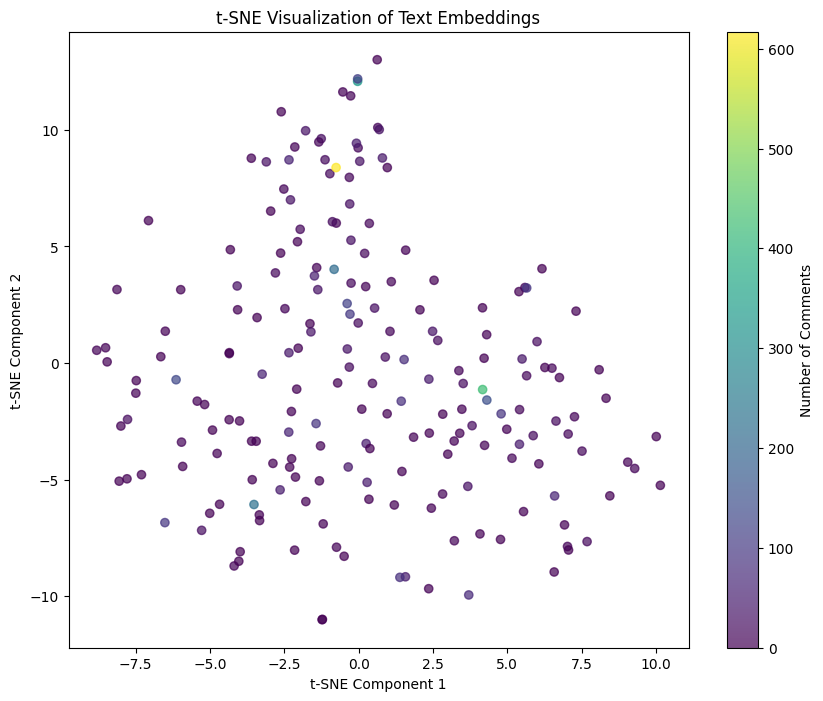

Epoch 10/500, Loss: 4360.9604
Epoch 20/500, Loss: 4287.2881
Epoch 30/500, Loss: 4219.3423
Epoch 40/500, Loss: 4203.5864
Epoch 50/500, Loss: 4193.7324
Epoch 60/500, Loss: 4188.5659
Epoch 70/500, Loss: 4183.2598
Epoch 80/500, Loss: 4173.8057
Epoch 90/500, Loss: 4152.9487
Epoch 100/500, Loss: 4119.1660
Epoch 110/500, Loss: 4116.0547
Epoch 120/500, Loss: 4077.2629
Epoch 130/500, Loss: 4137.1636
Epoch 140/500, Loss: 4046.7715
Epoch 150/500, Loss: 4008.1973
Epoch 160/500, Loss: 4268.9976
Epoch 170/500, Loss: 4079.6125
Epoch 180/500, Loss: 4086.3040
Epoch 190/500, Loss: 4052.0437
Epoch 200/500, Loss: 4012.5386
Epoch 210/500, Loss: 3948.3262
Epoch 220/500, Loss: 4431.5669
Epoch 230/500, Loss: 4030.3445
Epoch 240/500, Loss: 4002.1379
Epoch 250/500, Loss: 3954.6067
Epoch 260/500, Loss: 3894.5112
Epoch 270/500, Loss: 3824.6360
Epoch 280/500, Loss: 4679.5088
Epoch 290/500, Loss: 4234.1440
Epoch 300/500, Loss: 4188.2910
Epoch 310/500, Loss: 4136.6074
Epoch 320/500, Loss: 4086.0845
Epoch 330/500, Lo

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_absolute_error

# Function to get t-SNE embeddings
def apply_tsne(embeddings, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    return reduced_embeddings

# Apply t-SNE for dimensionality reduction
reduced_text_embeddings_tsne = apply_tsne(text_embeddings, n_components=2)

# Plot t-SNE results for visualization
plt.figure(figsize=(10, 8))
plt.scatter(reduced_text_embeddings_tsne[:, 0], reduced_text_embeddings_tsne[:, 1], c=df['Num of Comments'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Number of Comments')
plt.title('t-SNE Visualization of Text Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Define GNN model with dropout
class GNNModelWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=500, hidden_dim3=200, hidden_dim4=60, output_dim=1):
        super(GNNModelWithDropout, self).__init__()  # Fixed class name to GNNModelWithDropout
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.fc = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Set device to CUDA or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming criterion is defined as MSELoss
criterion = nn.MSELoss()

# Prepare data tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

# Train GNN model with dropout
model_with_dropout = GNNModelWithDropout(input_dim=X_train.shape[1]).to(device)  # Correct input dimension
optimizer = torch.optim.Adam(model_with_dropout.parameters(), lr=0.01)

num_epochs = 500  # Define the number of epochs

for epoch in range(num_epochs):
    model_with_dropout.train()
    optimizer.zero_grad()
    output = model_with_dropout(X_train_tensor, edge_index_train.to(device)).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Evaluate GNN model with dropout
model_with_dropout.eval()
with torch.no_grad():
    edge_index_test = create_edge_index_knn(X_test, k).to(device)
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model_with_dropout(test_X_tensor, edge_index_test).squeeze()
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')

    # Calculate MAE
    test_mae = mean_absolute_error(y_test, test_output.cpu().numpy())
    print(f'Test MAE: {test_mae:.4f}')


#IsoMap

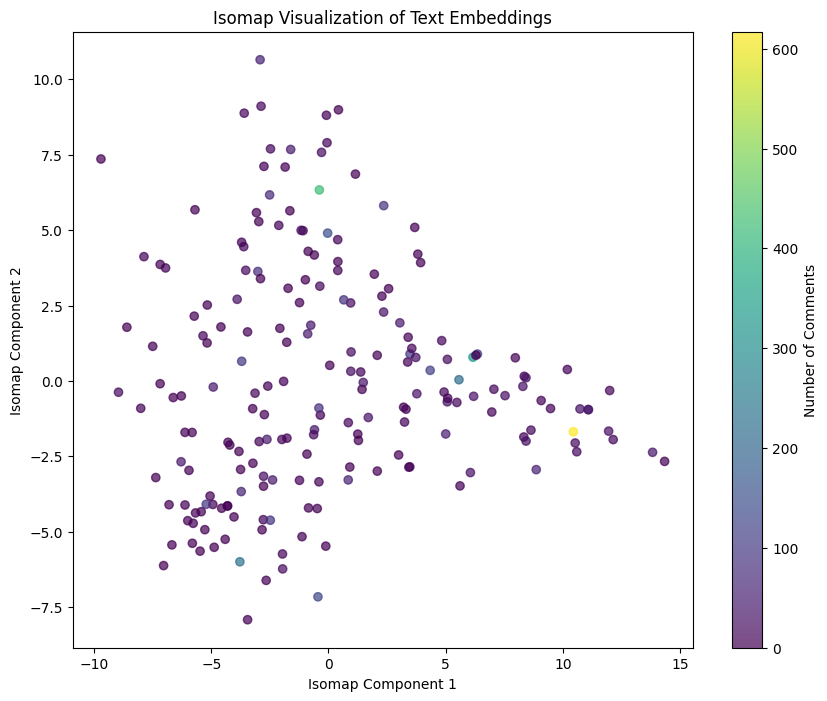

Epoch 10/500, Loss: 4980.8428
Epoch 20/500, Loss: 4512.6084
Epoch 30/500, Loss: 4282.9365
Epoch 40/500, Loss: 4212.6460
Epoch 50/500, Loss: 4210.6592
Epoch 60/500, Loss: 4202.1519
Epoch 70/500, Loss: 4195.4253
Epoch 80/500, Loss: 4192.1396
Epoch 90/500, Loss: 4189.5830
Epoch 100/500, Loss: 4187.1152
Epoch 110/500, Loss: 4184.5586
Epoch 120/500, Loss: 4180.0859
Epoch 130/500, Loss: 4169.6865
Epoch 140/500, Loss: 4144.2588
Epoch 150/500, Loss: 4110.0986
Epoch 160/500, Loss: 4095.1868
Epoch 170/500, Loss: 4065.6216
Epoch 180/500, Loss: 4208.9448
Epoch 190/500, Loss: 4091.4023
Epoch 200/500, Loss: 4063.0442
Epoch 210/500, Loss: 4007.5137
Epoch 220/500, Loss: 3969.9546
Epoch 230/500, Loss: 4203.3682
Epoch 240/500, Loss: 4157.7314
Epoch 250/500, Loss: 4054.2036
Epoch 260/500, Loss: 4094.2234
Epoch 270/500, Loss: 4026.5298
Epoch 280/500, Loss: 3954.3628
Epoch 290/500, Loss: 3891.8008
Epoch 300/500, Loss: 3869.9829
Epoch 310/500, Loss: 3691.5054
Epoch 320/500, Loss: 3795.7715
Epoch 330/500, Lo

In [ ]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_absolute_error

# Function to get Isomap embeddings
def apply_isomap(embeddings, n_components=2, n_neighbors=5):
    isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
    reduced_embeddings = isomap.fit_transform(embeddings)
    return reduced_embeddings

# Apply Isomap for dimensionality reduction
reduced_text_embeddings_isomap = apply_isomap(text_embeddings, n_components=2)

# Plot Isomap results for visualization
plt.figure(figsize=(10, 8))
plt.scatter(reduced_text_embeddings_isomap[:, 0], reduced_text_embeddings_isomap[:, 1], c=df['Num of Comments'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Number of Comments')
plt.title('Isomap Visualization of Text Embeddings')
plt.xlabel('Isomap Component 1')
plt.ylabel('Isomap Component 2')
plt.show()

# Define GNN model with dropout
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=900, hidden_dim2=500, hidden_dim3=200, hidden_dim4=60, output_dim=1):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.fc = nn.Linear(hidden_dim4, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)
        return x

# Set device to CUDA or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming criterion and optimizer are defined somewhere before this part
criterion = nn.MSELoss()

# Train GNN model with dropout
model_with_dropout = GNNModel(input_dim=X_train.shape[1]).to(device)  # Fix input_dim
optimizer = torch.optim.Adam(model_with_dropout.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)

num_epochs = 500  # Number of epochs
for epoch in range(num_epochs):
    model_with_dropout.train()
    optimizer.zero_grad()
    output = model_with_dropout(X_train_tensor, edge_index_train.to(device)).squeeze()
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

# Evaluate GNN model with dropout
model_with_dropout.eval()
with torch.no_grad():
    edge_index_test = create_edge_index_knn(X_test, k).to(device)
    test_X_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    test_output = model_with_dropout(test_X_tensor, edge_index_test).squeeze()
    test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float).to(device))
    print(f'Test Loss: {test_loss.item():.4f}')

    # Calculate MAE
    test_mae = mean_absolute_error(y_test, test_output.cpu().numpy())
    print(f'Test MAE: {test_mae:.4f}')
